In [1]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
from rasterio.windows import Window

# Reading single band image

In [2]:
def read_single_band_image(file_name):
    img = rasterio.open(file_name)
    band=img.read(1)
    return img,band
    

# reading pixels arrays 

In [3]:
def read_pixel_array(b1_in,b2_in):
    
    width,height=b1_in.shape
    
    b11_in=b1_in * b1_in
    b22_in=b2_in*b2_in
    b12_in=b1_in*b2_in
    
     #flatten the arrarys 
    b1_in_flat=b1_in.flatten()
    b2_in_flat=b2_in.flatten()
    b11_in_flat=b11_in.flatten()
    b22_in_flat=b22_in.flatten()
    b12_in_flat=b12_in.flatten()
    b_in_list =list((b1_in_flat,b2_in_flat, b11_in_flat,b22_in_flat,b12_in_flat)) 
    return b_in_list,width,height

# Sliding window aggregration

In [4]:
def sliding_window(band_in_list,width,height,w_size,method):
    
    delta=w_size//2
    col_extent_old = width - delta + 1
    col_extent = width - w_size + 1
    row_extent = height - w_size + 1
    
    #select the block indecies
    selector = np.array((0,delta,(delta*col_extent_old),(delta*col_extent_old+delta)))
    
    # Get offsetted indices across the height and width of input array
    output_index_set = np.arange(row_extent)[:,None]*col_extent_old + np.arange(col_extent)
    full_selector = selector.ravel()[:,None] + output_index_set.ravel()
    
    #implement the selector on the arrays
    b1_in_selc=np.take(band_in_list[0],full_selector)
    
     
    b2_in_selc=np.take(band_in_list[1],full_selector)
    b11_in_selc=np.take(band_in_list[2],full_selector)
    b22_in_selc=np.take(band_in_list[3],full_selector)
    b12_in_selc=np.take(band_in_list[4],full_selector)
    
    if method=='sum':
        b1_out=b1_in_selc.sum(axis=0)
        b2_out=b2_in_selc.sum(axis=0)
        b11_out=b11_in_selc.sum(axis=0)
        b22_out=b22_in_selc.sum(axis=0)
        b12_out=b12_in_selc.sum(axis=0)
    elif method=='mean':
        b1_out=b1_in_selc.mean(axis=0)
        b2_out=b2_in_selc.mean(axis=0)
        b11_out=b11_in_selc.mean(axis=0)
        b22_out=b22_in_selc.mean(axis=0)
        b12_out=b12_in_selc.mean(axis=0)
    band_out_list=list((b1_out,b2_out,b11_out,b22_out,b12_out))
    return band_out_list
    
    

# NDVI

In [5]:
def ndvi(band_out_list):
    np.seterr(divide='ignore', invalid='ignore')
    return (band_out_list[1]-band_out_list[0])/(band_out_list[1]+band_out_list[0])

# Window Regression

In [6]:
def windowRegression(band_out_list,w, x_max=5000,y_max=5000):
    x_diff = x_max-w+1
    y_diff = y_max-w+1
    size = band_out_list[0].size
    count = w*w
    m = np.empty(size)
    
    if any(band.size!=size for band in band_out_list):
        print(size)
        #print(band.size)
        raise ValueError('In windowRegression: x_max and/or y_max inconsistent with length of a, b, aa, and / or ab')

    numerator = count * band_out_list[-1] - band_out_list[0]* band_out_list[1]
    denominator = count * band_out_list[2] - band_out_list[0] * band_out_list[0]
    m = numerator/denominator
    return m

    

# Window Correlation

In [7]:
def windowPearson(band_out_list,w, x_max=300,y_max=300):
    x_diff = x_max-w+1
    y_diff = y_max-w+1
    size = band_out_list[0].size
    count = w*w
    pearson = np.empty(count)
    if any(band.size!=size for band in band_out_list):
        raise ValueError('In windowPearson: x_max and/or y_max inconsistent with length of a, b, aa, ab, and / or bb')
    
    numerator = count * band_out_list[-1] - band_out_list[0]* band_out_list[1]
    denominator = np.sqrt(count * band_out_list[2] - band_out_list[0] * band_out_list[0]) * np.sqrt(count * band_out_list[3] - band_out_list[1] * band_out_list[1])
    pearson = numerator / denominator
    return pearson

# Writing images

In [8]:
#def write_image(...):
   # fig

In [9]:
def create_tree_plot(red_band_file,nir_band_file,window_size):
    '''
    bands=[]
    for img_file in img_files:
        bands.append(read_single_band_image(img_file))
    for
    '''
    red_img,red_band=read_single_band_image(red_band_file)
    nir_img,nir_band=read_single_band_image(nir_band_file)
    plt.imshow(red_band)
    band_in_list,width,height=read_pixel_array(red_band,nir_band)
    wout_size=2
    plot_index=1
    kwargs=red_img.meta
    kwargs.update(driver='GTiff', width=20000, height=15000, count=1,dtype=rasterio.float64)
    raster_plt=rasterio.open('result.tif','w',**kwargs)
    col_offset,row_offset=0,0
    while wout_size<=window_size:
       
        band_out_list=sliding_window(band_in_list,width,height,wout_size,'sum')
        ndvi_arr=ndvi(band_out_list)
        reg=windowRegression(band_out_list,wout_size, x_max=300,y_max=300)
        pearson=windowPearson(band_out_list,wout_size, x_max=300,y_max=300)
       # print(ndvi_arr,ndvi_arr.shape)
       # plt.imshow(ndvi_arr)
        print(reg,reg.shape)
       # plt.imshow(reg)
        print(pearson,pearson.shape)
      #  plt.imshow(pearson)
        raster_plt.write(np.clip(ndvi_arr,0,1).reshape(width-wout_size+1,height-wout_size+1).astype(rasterio.float64),window=Window(col_offset,row_offset,300,300),indexes=1)
        raster_plt.write(np.clip(reg,0,1).reshape(width-wout_size+1,height-wout_size+1).astype(rasterio.float64),window=Window(col_offset,row_offset+1*300,300,300),indexes=1)
        raster_plt.write(np.clip(pearson,0,1).reshape(width-wout_size+1,height-wout_size+1).astype(rasterio.float64),window=Window(col_offset,row_offset+2*300,300,300),indexes=1)
        wout_size*=2
        col_offset+=300
    raster_plt.close()
        
    
    
        
        

CPLE_AppDefinedError: TIFFReadDirectory:Failed to read directory at offset 505273416

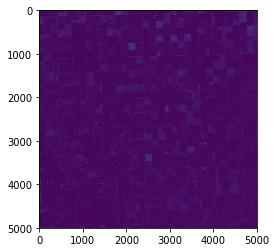

In [10]:
create_tree_plot('r322_14b_red.tif','r322_14b_nir.tif',32)

In [11]:
red_img,red_band=read_single_band_image('r322_14b_red.tif')
nir_img,nir_band=read_single_band_image('r322_14b_nir.tif')
np.seterr(divide='ignore', invalid='ignore')
ndvi= (nir_band.astype(float)-red_band.astype(float))/(nir_band+red_band)
np.nanmax(ndvi), np.nanmin(ndvi)
kwargs=red_img.meta
kwargs.update(
    dtype=rasterio.float32,
    count = 1)

# Write band calculations to a new raster file
with rasterio.open('ndvi.tif', 'w', **kwargs) as dst:
        dst.write_band(1, ndvi.astype(rasterio.float32))

TypeError: __init__() got an unexpected keyword argument 'vmax'

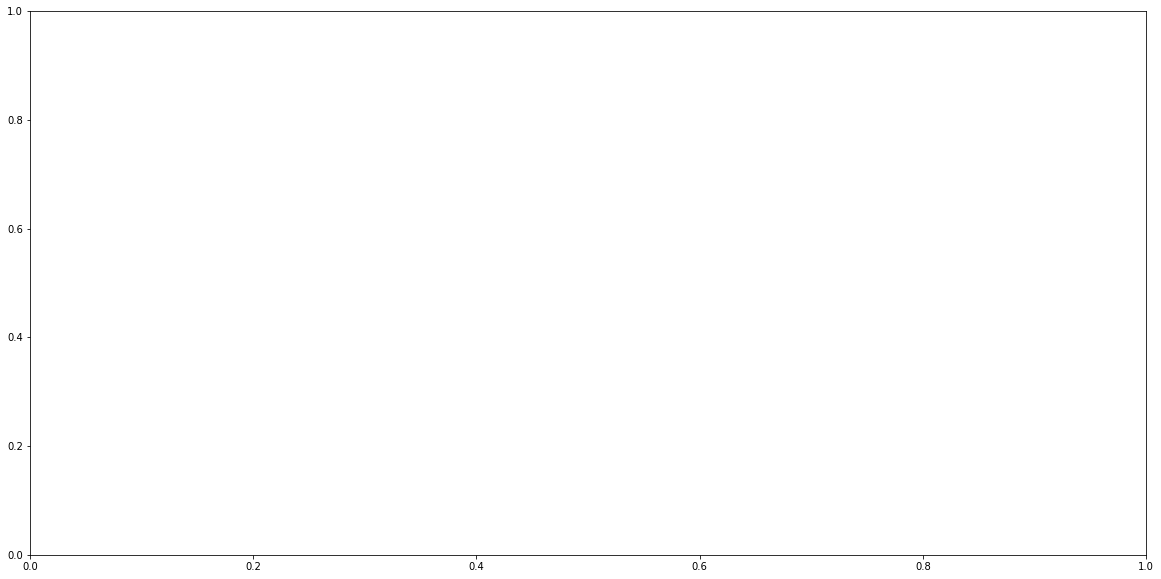

In [12]:
import matplotlib.colors as colors

class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmat=None, midpoint=None, clip=False):
        self.midpoint=midpoint
        colors.Normalize.__init__(self,vmin,vmax,clip)
    def __call__(self,value,clip=None):
        x,y=[self.vmin,self.midpoint,self.vmax],[0,0.5,1]
        return np.ma,masked_array(np.interp(value,x,y),np.isnan(value))
    
min=np.nanmin(ndvi)
max=np.nanmax(ndvi)
mid=0.1

fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)

# diverging color scheme chosen from https://matplotlib.org/users/colormaps.html
cmap = plt.cm.RdYlGn 

cax = ax.imshow(ndvi, cmap=cmap, clim=(min, max), norm=MidpointNormalize(midpoint=mid,vmin=min, vmax=max))

ax.axis('off')
ax.set_title('Normalized Difference Vegetation Index', fontsize=18, fontweight='bold')

cbar = fig.colorbar(cax, orientation='horizontal', shrink=0.65)

fig.savefig("ndvi-fig.png", dpi=200, bbox_inches='tight', pad_inches=0.7)

plt.show()

In [11]:
image = np.ones((4999, 4999))
#image=nir
print(image.shape)
with rasterio.open(
        'example.tif', 'w',
        driver='GTiff', width=500, height=300, count=1,
        dtype=image.dtype) as dst:
    dst.write(image, window=Window(50, 30, 250, 150), indexes=1)

(4999, 4999)


In [52]:
result=rasterio.open('result.tif','r')
res_arr=result.read(1)
res_arr[-300:,-300:]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

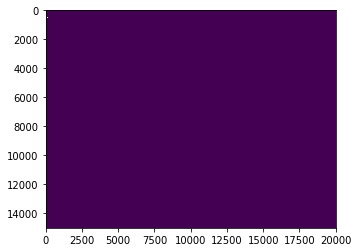

In [51]:
plt.imshow(res_arr)
plt.show()

In [16]:
res=rasterio.open('result17Jan31.tif')
res_arr=res.read(1)
res_arr

array([[  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       ...,
       [  0,   0,   0, ..., 255, 255, 255],
       [  0,   0,   0, ..., 255, 255, 255],
       [255, 255, 255, ..., 255, 255, 255]], dtype=uint8)